# Projeto do Trainee: Visão Computacional
Esse notebook foi realizado por Wesley Pereira para o projeto do trainee de CV do primeiro semestre de 2020.<br/>
<img src="https://i.ibb.co/DtHQ3FG/802x265-Logo-GT.png" width="400"><br/>
O projeto é constutuído de 2 partes principais:
<ul>
<li> Exercícios preliminares de manipulação de imagens para introduzir o trainee ao assunto; </li>
<li> Cosntrução de redes neurais simples para classificar um conjunto de imagens que possui 3 categorias distintas: Darth Vader, Stormtrooper e Yoda. </li>
<ul>

## 1. Exercícios de manipulação
Os exercícios de manipulação foram realizados da forma mais simples possível <s>acho que a ideia era ser simples mesmo</s> visando gastar a maior parte do tempo pensando na arquitetura da rede neural.<br>
Antes de mais nada vamos importar as bibliotecas necessárias

In [1]:
from PIL import Image
import PIL
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from scipy.signal import convolve
from scipy.ndimage import rotate, zoom
import torchvision
from torchvision import transforms
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets
from torch.utils.data import DataLoader, SubsetRandomSampler
from random import randint, random
import datetime

Aqui coloque o caminho para imagem que utilizaremos de exemplo nos 4 primeiros exercícios:

In [2]:
# Altere aqui o caminho até a imagem que deseja exibir
PATH_TO_IMAGE = './dataset/Yoda/download16.jpg'

### 1.1 Visualização uma imagem
Foi feita uma função simples <code>visualiza_imagem</code> que recebe o caminho para uma imagem e também o tipo de visualização (pillow, opencv ou matplot) e exibe ela.

In [3]:
# Função que visualiza uma imagem de 3 formas diferentes: pillow, opencv e matplot 
def visualiza_imagem(path_to_img, show_type):
    
    if show_type == 'pillow':
        display(Image.open(path_to_img))
        
    if show_type == 'opencv':
        img = cv.imread(path_to_img)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB) # Inverte os canais pois com openCV o canal Blue é o primeiro
        plt.xticks([]), plt.yticks([])           # Desabilita os eixos trolls
        plt.imshow(img)
        
    if show_type == 'matplot':
        plt.xticks([]), plt.yticks([])           # Desabilita os eixos trolls
        plt.imshow(mpimg.imread(path_to_img))

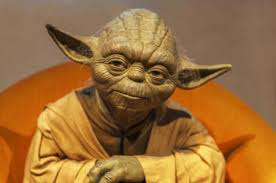

In [4]:
visualiza_imagem(PATH_TO_IMAGE, 'pillow') # Altere o tipo para ver as outras plotagens

---

In [5]:
# Função auxiliar para plotar duas imagens lado a lado
def plota_lado_a_lado(img, tit_img, outra_img, tit_outra_img, img_gray=False, outra_img_gray=False):
    plt.figure(figsize=(8.5,5))

    #Plota img
    plt.subplot(121)
    plt.imshow(img, cmap='gray') if img_gray else plt.imshow(img)
    plt.title(tit_img)
    plt.xticks([]), plt.yticks([])

    #Plota outra_img
    plt.subplot(122)
    plt.imshow(outra_img, cmap='gray') if outra_img_gray else plt.imshow(outra_img)
    plt.title(tit_outra_img)
    plt.xticks([]), plt.yticks([])
    
    plt.show()

---

### 1.2 Imagem preta e branca (grayscale)
Bom, aqui a única coisa que fui foi fazer a média dos três canais de cores para obter um único canal. A partir disso, como o matplot, por definição, considera um mapa de cor azul/verde para um canal único, apenas alterei o mapa de cor para considerar uma imagem em grayscale.

In [6]:
# Função que transforma uma imagem em grayscale
def ImgToGrayscale(img):
    img_bew = np.mean(img[...,:3], -1)
    return img_bew

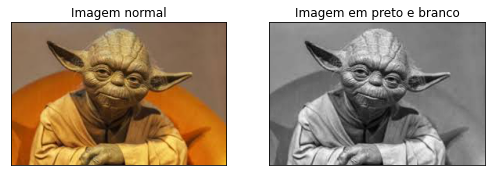

In [7]:
img = mpimg.imread(PATH_TO_IMAGE)
img_bew = ImgToGrayscale(img)
plota_lado_a_lado(img, 'Imagem normal', img_bew, 'Imagem em preto e branco', True, True)

### 1.3 Data augmentation "na mão"
Basicamente aqui foi feita uma função que recebe uma imagem e um parâmetro que indica qual tipo de modificação é pra ser feita na imagem:
<ul>
    <li><code>"flip"</code>: inverte a imagem;</li>
    <li><code>"rotacionar"</code>: rotaciona a imagem em um ângulo aleatório entre 10 e 45°;</li>
    <li><code>"contraste"</code>: adiciona contraste a partir de um fator aleatório;</li>
    <li><code>"brilho"</code>: adiciona brilho a partir de um fator aleatório;</li>
</ul>

In [8]:
# Função que aplica uma determinada alteração numa imagem
def data_quase_augmentation(img, tipo_mod, **kwargs):
    
    if tipo_mod == "flip":
        return np.fliplr(img)
    
    if tipo_mod == "rotacionar":
        num_aleat = randint(10, 45)
        return rotate(img, num_aleat, reshape=False)
    
    if tipo_mod == "contraste":
        num_aleat = random()*2 + 1
        return np.clip(128 + num_aleat * img - num_aleat * 128, 0, 255).astype(np.uint8)
    
    if tipo_mod == "brilho":
        num_aleat = random()/2 + 1.5
        return np.where((255-img)<img,255,img*num_aleat).astype(np.uint8)


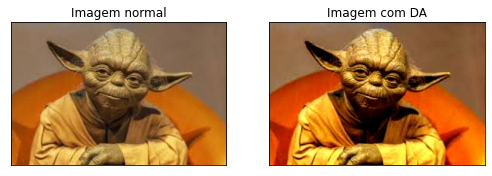

In [9]:
# Imagem base e imagem com data augmentation
img = mpimg.imread(PATH_TO_IMAGE)
img_arg = data_quase_augmentation(img, "contraste")

# Plota
plota_lado_a_lado(img, 'Imagem normal', img_arg, 'Imagem com DA')

### 1.4 Filtros
A ideia aqui era criar um filtro de Sobel "na mão". Para ser um filtro 100% na mão era necessário fazer a convolução passo a passo, a partir da definição dela. Por pura preguiça usei a scipy para fazer a convolução. O filtro de Sobel feito é bom para identificar borda verticais e detecta também algumas nuances de bordas horizontais também devido aos menores valores na linha no meio da matriz. <s>Em seguida alguns filtros de blur foram plotados porque o enunciado pedia.</s>

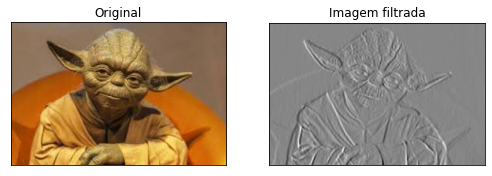

In [10]:
# Função que aplica um filtro de Sobel sobre uma image qualquer
def SobelFilter(img):
    kernel = np.zeros((3,3))
    kernel[:, 0] = -1
    kernel[:, 2] = 1
    kernel[1, [0, 2]] = [-2, 2]
    
    img_filtrada = 0
    for channel in range(img.shape[2]):
        img_filtrada += convolve(img[:,:,channel], kernel, mode='valid')
    
    return img_filtrada

# Imagens de base e filtrada
img = mpimg.imread(PATH_TO_IMAGE)
img_filtrada = SobelFilter(img)

# Plota
plota_lado_a_lado(img, 'Original', img_filtrada, 'Imagem filtrada', False, True)

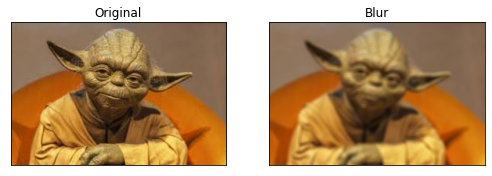

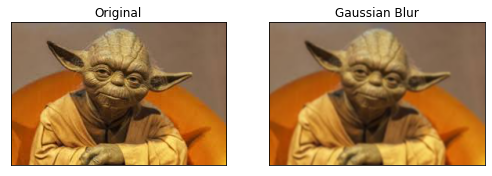

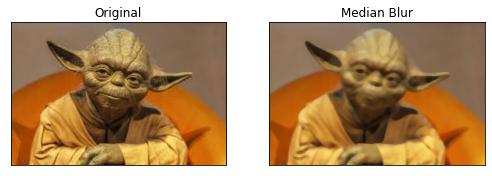

In [11]:
# Aplica os filtros
blurImg = cv.blur(img, (5,5))
gaussianBlurImg = cv.GaussianBlur(img, (5,5), 0)
medianBlurImg = cv.medianBlur(img, 5)

# Plota as imagens
plota_lado_a_lado(img, 'Original', blurImg, 'Blur')
plota_lado_a_lado(img, 'Original', gaussianBlurImg, 'Gaussian Blur')
plota_lado_a_lado(img, 'Original', medianBlurImg, 'Median Blur')

## 2. Exercícios de classificação
Os exercícios de classificação consistiam em organizar um diretório para ser utilizado como dataset e com isso desenvolver diferentes arquiteturas para verificar o comportamento de uma rede neural conforme uma complexidade é variada. Nessa parte realizei a construção de 3 redes neurais:
1. Rede neural linear simples para classificar as imagens;
2. Rede neural convolucional simples para comparar as diferenças de usar ou não a convolução;
3. Rede neural melhora, vamos ver o que sai.<br>

Antes de começar os exercícios em si, vamos definir um conjunto de funções que serão úteis ao longo das implementações.

In [12]:
# Função que devolve um subconjunto de um array a partir dos índices passados
def subconjunto(indices, ini, fim):
    return indices[ini : ini + fim]

In [13]:
# Função que recebe uma imagem PYTORCH normaliza, desnormaliza, ajeita as dimensões e plota
# OBS: Quando carregamos imagens com o auxílio do torch o canal de cores vem na primeira dimensão
def imshow(img, rotulo):
    img = img / 2 + 0.5     # desnormaliza
    npimg = img.numpy()
    
    plt.figure(figsize=(5,2.5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title('Rotulo: '+ str(rotulo))
    plt.show()

In [15]:
# Função que recebe um modelo treinado e um conjunto de dados de teste e retorna a acurácia
# do modelo em porcentagem
def acuracia_pct(modelo, dados_teste, device):
    corretas = 0
    total = 0
    with torch.no_grad():
        for dado in dados_teste:
            imagens, rotulos = dado
            saidas = modelo(imagens.to(device))
            _, predicoes = torch.max(saidas.data, 1)
            total += rotulos.size(0)
            corretas += (predicoes.cpu() == rotulos).sum().item()
    
    return 100 * corretas / total

In [16]:
# Função que plota a loss de treino ao longo das épocas
def plot_losses(losses_treino):

    losses_treino_array = np.array(losses_treino)

    fig, ax = plt.subplots(figsize = (5, 2.5))

    ax.plot(losses_treino_array, color='blue') 
    ax.set(title="Loss ao longo das épocas", 
            xlabel='Epoch',
            ylabel='Loss') 

In [17]:
# Função que realiza um passo do treino (por toda uma época) e retorna
# modelo, otimizador, epoch_loss_mean atualizados
def treino(train_loader, modelo, criterio, otimizador, device):
    
    epocas_loss = []
    for batch in train_loader:

        dado, rotulo = batch

        # Forward 
        pred = modelo.forward(dado.to(device))
        loss = criterio(pred.to(device), rotulo.to(device))
        epocas_loss.append(loss.data.cpu())

        # Backward
        otimizador.zero_grad()
        loss.backward()
        otimizador.step()
        
    epocas_loss = np.asarray(epocas_loss)
    epoca_loss_media = epocas_loss.mean()
    
    return modelo, otimizador, epoca_loss_media
    

In [18]:
def loop_treino(train_loader, test_loader, modelo, criterio, otimizador, epocas, device, print_every=1):
    
    # array de Loss ao longo do treino
    losses_treino = []

    start = datetime.datetime.now()
    for epoca in range(epocas):
        
        
        # Aplica um passo do treino
        modelo, otimizador, epoca_loss_media = treino(train_loader, modelo, criterio, otimizador, device)
        
        if (epoca + 1) % print_every == 0:
            
            # Calcula acurácia até aquele momento
            accu_treino = acuracia_pct(modelo, test_loader, device)
            
            # Printa
            print("Epoca %3d | Loss: %4.3f | Acc: %4.2f%%" % (epoca+1, epoca_loss_media, accu_treino))
        
        losses_treino.append(epoca_loss_media)

    end = datetime.datetime.now()
    # Imprime tempo total de treino
    tempo = end - start
    min = str(int(tempo.seconds/60)) if int(tempo.seconds/60) > 9 else "0" + str(int(tempo.seconds/60))
    sec = str(int(tempo.seconds%60)) if int(int(tempo.seconds%60)) > 9 else "0" + str(int(tempo.seconds%60))
    print("Tempo total de treino (min:sec): " + min + ":" + sec)
        
    return modelo, otimizador, losses_treino

Vamos ver agora se podemos usar a GPU do Colab

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


Agora sim podemos continuar...<br>
### 2.1 e 2.2 Preperar o dataset
Aqui, o exercício pedia para dividir o diretório com os dados em duas partes, uma de treino e uma de testes e, em seguida, tornar isso de fato um dataset apropriado para a biblioteca que o trainee fosse usar. Como o PyTorch já possui uma função nativa para fazer tal ação, que recebe uma pasta no formato:
```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png
root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
```
Tomei a liberdade de usar diretamente o diretório dado. Alguns passos da divisão do dataset no PyTorch são mais "manuais" do que com o TF, então achei seria problema fazer dessa forma.<br>
Vamos definir nossos hiperparâmetros que serão utilizados ao longo dos 3 primeiros exercícios:

In [20]:
hyper_params = {
    'batch_size': 24,
    'num_workers': 4,
    'num_classes': 3,
    'num_epochs': 10,
    'lr': 1e-4,
    'weight_decay': 5e-3,
    'train_dataset_pct': 0.8,
    'img_size': 100
}

Agora sim! Fazendo os exercícios em si:

In [21]:
dataset = torchvision.datasets.ImageFolder("./dataset", 
                                           transform=transforms.Compose([
                                            transforms.Resize((hyper_params['img_size'], hyper_params['img_size'])), 
                                            transforms.ToTensor(), 
                                            transforms.Normalize(0.5, 0.5, 0.5)
                                           ]))

In [22]:
# Pega o número máximo de imagens no dataset de treino
treino_max_val = int(len(dataset) * hyper_params['train_dataset_pct'])

# Gera os índices aleatório no range do dataset
indices = torch.randperm(len(dataset))

# Capta os índices dos subconjuntos
train_indices = subconjunto(indices, 0, treino_max_val)
test_indices = subconjunto(indices, treino_max_val, len(dataset))

In [23]:
# Divide os dataloaders de test e de train
dataloaders = {
    "treino": torch.utils.data.DataLoader(
        dataset, sampler=SubsetRandomSampler(train_indices), batch_size=hyper_params['batch_size']
    ),
    "teste": torch.utils.data.DataLoader(
        dataset, sampler=SubsetRandomSampler(test_indices), batch_size=hyper_params['batch_size']
    )
}

Vamos ver se tudo deu certo até aqui... Iremos ver o tamanho de um batch e uma imagem.

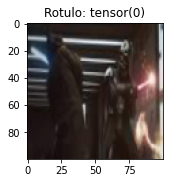

In [24]:
data_iter = iter(dataloaders["treino"])
imagens, rotulos = data_iter.next()
imshow(imagens[0], rotulos[0])

### 2.3 Rede neural simples (sem CNN)
Neste exercício com feita uma rede neural simples com estrutura composta somente de camadas lineares. Dito isso, a rede neural foi construída conforme mostrado abaixo:

In [33]:
class RedeSimples(nn.Module):

    def __init__(self, entrada_tam, camadas_tam, saida_tam):
        super(RedeSimples, self).__init__()

        # Define uma rede senquencial com camadas lineares seguidas de ReLU
        self.estrut_camadas  = nn.Sequential(
                          nn.Linear(entrada_tam, camadas_tam),
                          nn.ReLU(),
                          nn.Dropout(0.5),
                          nn.Linear(camadas_tam, camadas_tam),
                          nn.ReLU(),
                          nn.Dropout(0.5),
                          nn.Linear(camadas_tam, int(camadas_tam/4)),
                          nn.ReLU(),
                          nn.Dropout(0.2)
                        )
        self.q_saida     = nn.Linear(int(camadas_tam/4), saida_tam)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        
        # Transforma a imagem em um vetor 1xN
        x = x.view(x.size(0), -1)
        
        camadas = self.estrut_camadas(x)
        saida  = self.softmax(self.q_saida(camadas))

        return saida

In [34]:
# Aqui definimos o tamanho da entrada
entrada_tam  = hyper_params['img_size'] * hyper_params['img_size'] * 3

# Não foi colocado como um hiperparâmetros, pois esse valor irá variar conforme a arquitetura utilizada
camadas_tam = 1024

# Número de canais de saída == número de classes do problema
saida_tam = hyper_params['num_classes']

# Cria a rede em si
redeSimples = RedeSimples(entrada_tam, camadas_tam, saida_tam).to(device)

In [35]:
# Define o critério de cálculo da perda
criterio = nn.CrossEntropyLoss().to(device)

# Define o critério de cálculo para atualizar os pesos e o bias
otimizador = optim.Adam(redeSimples.parameters(), lr=hyper_params['lr'], weight_decay=hyper_params['weight_decay'])

In [36]:
model, optimizer, losses_treino = loop_treino(dataloaders['treino'], 
                                              dataloaders['teste'], 
                                              redeSimples, 
                                              criterio, 
                                              otimizador, 
                                              hyper_params['num_epochs'],
                                              device)

Epoca   1 | Loss: 0.979 | Acc: 65.30%
Epoca   2 | Loss: 0.912 | Acc: 59.56%
Epoca   3 | Loss: 0.887 | Acc: 61.75%
Epoca   4 | Loss: 0.875 | Acc: 66.94%
Epoca   5 | Loss: 0.864 | Acc: 69.13%
Epoca   6 | Loss: 0.841 | Acc: 65.03%
Epoca   7 | Loss: 0.849 | Acc: 62.84%
Epoca   8 | Loss: 0.842 | Acc: 69.95%
Epoca   9 | Loss: 0.819 | Acc: 64.48%
Epoca  10 | Loss: 0.826 | Acc: 68.58%
Tempo total de treino (min:sec): 01:19


Acurácia final do modelo no dataset de teste: 65.57%



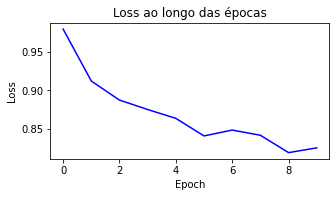

In [41]:
accu_simple = acuracia_pct(model, dataloaders['teste'], device)
print("Acurácia final do modelo no dataset de teste: %4.2f%%\n" %(accu_simple))

plot_losses(losses_treino)

Considerando que a rede utiliza não possui nenhuma camada convolucional e a quantida de dados é baixa, um resultado por volta de 60% é bom. Vamos analisar agora como se comporta uma rede simples, mas adicionando camadas convolucionais.

### 2.4 Rede neural simples (com CNN)
Neste exercício com feita uma rede neural simples com a estrutura composts de apenas duas camadas convolucionais com 16 filtros e uma camada linear.
Neste caso, após alguns testes foram escolhidos os seguintes valores para os hiperparâmetros:

In [42]:
hyper_params = {
    'batch_size': 24,
    'num_workers': 4,
    'num_classes': 3,
    'num_epochs': 10,
    'lr': 1e-4,
    'weight_decay': 5e-3,
    'train_dataset_pct': 0.8,
    'img_size': 100
}

Com isso, a rede neural foi construída conforme mostrado abaixo:

In [43]:
class ConvRedeSimples(nn.Module):

    def __init__(self):
        super(ConvRedeSimples, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 5)
        self.fc1 = nn.Linear( 16 * 22 * 22, 3)
        self.drop = nn.Dropout(0.3)

    def forward(self, x):
        x = self.drop(self.pool(F.relu(self.conv1(x))))
        x = self.drop(self.pool(F.relu(self.conv2(x))))
        
        # Transforma o volume em array unidimensional
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc1(x))
        return x

In [44]:
# Instancia a rede convolucional simples
convRedeSimples = ConvRedeSimples().to(device)

In [45]:
# Define o critério de cálculo
criterio = nn.CrossEntropyLoss().to(device)

# Define o otimizador 
otimizador = optim.Adam(convRedeSimples.parameters(), lr=hyper_params['lr'], weight_decay=hyper_params['weight_decay'])

In [46]:
model, optimizer, losses_treino = loop_treino(dataloaders['treino'], 
                                              dataloaders['teste'], 
                                              convRedeSimples, 
                                              criterio, 
                                              otimizador, 
                                              hyper_params['num_epochs'],
                                              device)

Epoca   1 | Loss: 1.034 | Acc: 62.57%
Epoca   2 | Loss: 0.938 | Acc: 65.57%
Epoca   3 | Loss: 0.911 | Acc: 66.39%
Epoca   4 | Loss: 0.897 | Acc: 66.67%
Epoca   5 | Loss: 0.889 | Acc: 66.94%
Epoca   6 | Loss: 0.881 | Acc: 66.12%
Epoca   7 | Loss: 0.867 | Acc: 68.85%
Epoca   8 | Loss: 0.856 | Acc: 69.40%
Epoca   9 | Loss: 0.848 | Acc: 71.58%
Epoca  10 | Loss: 0.833 | Acc: 73.50%
Tempo total de treino (min:sec): 01:17


Acurácia final do modelo no dataset de teste: 72.40%



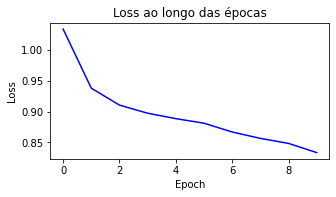

In [47]:
accu_simple = acuracia_pct(model, dataloaders['teste'], device)
print("Acurácia final do modelo no dataset de teste: %4.2f%%\n" %(accu_simple))

plot_losses(losses_treino)

Aqui, mesmo com uma rede convolucional bem simples, percebemos que já temos uma melhora significativa na acurácia do modelo, aumentando a acurácia cerca de 5%~7%. Por último, vamos tentar criar uma rede ainda melhor!

### 2.4 Rede neural melhorada (com CNN)
Neste exercício foi feita <s>uma tentativa de</s> uma rede neural um pouco mais elaborada que a anterior com três camadas convolucionais e mais algumas camadas fc. Neste caso foram feitos alguns testes com diversos valores diferentes de hiperparâmetros e estrutura de rede. Após alguns testes foram escolhidos os seguintes valores para os hiperparâmetros:

In [49]:
hyper_params = {
    'batch_size': 24,
    'num_workers': 4,
    'num_classes': 3,
    'num_epochs': 101,
    'lr': 3e-4,
    'weight_decay': 1e-3,
    'train_dataset_pct': 0.8,
    'img_size': 100
}

Em seguida, os dados anteriormente importados, foram recarregados, pois no PyTorch definimos as transformações (data augmentation) ao carregar os dados. Outro ponto que vale ser ressaltado é que no Torch, as transformações são feitas em tempo de execução, ou seja, em cada batch. Dessa forma, a cada época, os batchs são diferentes dos anteriores e, nesse sentido, o dat augmentation tem sentido no Torch apenas se treinarmos a rede por várias épocas. <br>
Com isso, adicionamos 3 transformações na imagem: Rotação aleatória, flip horizontal e flip vertical. Em seguida, mudamos o número de épocas para 100, pois como dito anteriormente a cada época as transformações são aplicadas nas imagens de modo aletório. Veja:

In [50]:
dataset = torchvision.datasets.ImageFolder("./dataset", transform=transforms.Compose([
                                                                        transforms.Resize((hyper_params['img_size'], hyper_params['img_size'])),
                                                                        transforms.RandomHorizontalFlip(),
                                                                        transforms.RandomVerticalFlip(),
                                                                        transforms.RandomRotation(90),
                                                                        transforms.ToTensor(), 
                                                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

In [51]:
class ConvRede(nn.Module):

    def __init__(self):
        super(ConvRede, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 32, 5)
        self.conv3 = nn.Conv2d(32, 32, 5)
        self.fc1 = nn.Linear( 32 * 9 * 9, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)
        self.drop = nn.Dropout(0.3)

    def forward(self, x):
        x = self.drop(self.pool(F.relu(self.conv1(x))))
        x = self.drop(self.pool(F.relu(self.conv2(x))))
        x = self.drop(self.pool(F.relu(self.conv3(x))))
        
        # Transforma o volume em array unidimensional
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [52]:
# Instancia a rede convolucional
convRede = ConvRede().to(device)

In [53]:
# Define o critério de cálculo
criterio = nn.CrossEntropyLoss().to(device)

# Define o otimizador 
otimizador = optim.Adam(convRede.parameters(), lr=hyper_params['lr'], weight_decay=hyper_params['weight_decay'])

In [54]:
model, optimizer, losses_treino = loop_treino(dataloaders['treino'], 
                                              dataloaders['teste'], 
                                              convRede, 
                                              criterio, 
                                              otimizador, 
                                              hyper_params['num_epochs'],
                                              device,
                                              10)

Epoca  10 | Loss: 0.769 | Acc: 73.50%
Epoca  20 | Loss: 0.715 | Acc: 74.86%
Epoca  30 | Loss: 0.671 | Acc: 77.87%
Epoca  40 | Loss: 0.627 | Acc: 80.33%
Epoca  50 | Loss: 0.604 | Acc: 80.60%
Epoca  60 | Loss: 0.598 | Acc: 78.96%
Epoca  70 | Loss: 0.578 | Acc: 81.97%
Epoca  80 | Loss: 0.577 | Acc: 80.05%
Epoca  90 | Loss: 0.572 | Acc: 80.33%
Epoca 100 | Loss: 0.576 | Acc: 80.87%
Tempo total de treino (min:sec): 10:36


Acurácia final do modelo no dataset de teste: 80.60%



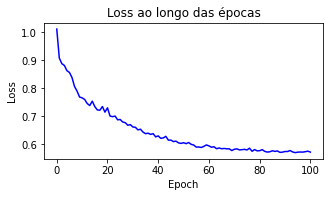

In [57]:
accu_simple = acuracia_pct(model, dataloaders['teste'], device)
print("Acurácia final do modelo no dataset de teste: %4.2f%%\n" %(accu_simple))

plot_losses(losses_treino)

**Ufa!** Conseguímos 80% de acurácia. A rede em questão obteve um bom resultado e nem se quer é uma rede tão complexa. Com certeza é possível melhorar a rede ainda mais, mas por falta de tempo mais testes não puderam ser feito.<br>

Alguns pontos gerais merecem destaque: <br>


*   Todas as redes foram testadas várias vezes para tentar encontrar valores aceitáveis;
*   A cada passo de testes as acurácias de teste e treino eram comparadas para evitar maiores problemas rs;

<br> Por fim, agradecimentos especiais a todos os membros de CV pela ajuda e incentivo, vlw flw.
